In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)


100%|██████████| 163M/163M [00:01<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
WITH_MASK_DIR = '/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/with_mask'
WITHOUT_MASK_DIR = '/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/without_mask'

In [4]:
with_mask_data = [(os.path.join(WITH_MASK_DIR, file), 1) for file in os.listdir(WITH_MASK_DIR)]
without_mask_data = [(os.path.join(WITHOUT_MASK_DIR, file), 0) for file in os.listdir(WITHOUT_MASK_DIR)]
all_data = with_mask_data + without_mask_data

In [5]:
df = pd.DataFrame(all_data, columns=['file_path', 'label'])

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [7]:
def load_and_preprocess_images(df, target_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        image = Image.open(row['file_path']).convert('RGB')
        image = image.resize(target_size)
        image_array = np.array(image) / 255.0  # Normalize image
        images.append(image_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

In [8]:
X_train, y_train = load_and_preprocess_images(train_df)
X_test, y_test = load_and_preprocess_images(test_df)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (6042, 224, 224, 3)
Training labels shape: (6042,)
Testing data shape: (1511, 224, 224, 3)
Testing labels shape: (1511,)


In [10]:
plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

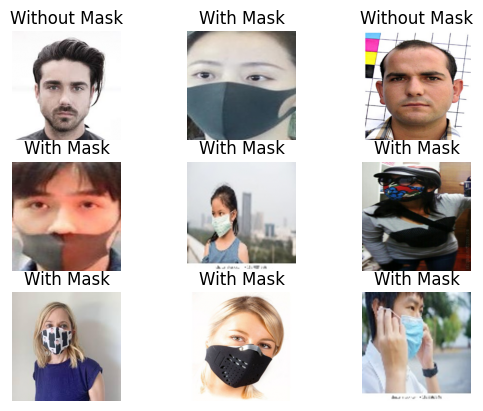

In [12]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title("With Mask" if y_train[i] == 1 else "Without Mask")
    plt.axis("off")
plt.show()

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
189/189 [==============================] - 73s 379ms/step - loss: 0.4321 - accuracy: 0.8411 - val_loss: 0.2794 - val_accuracy: 0.8875
Epoch 2/10
189/189 [==============================] - 69s 367ms/step - loss: 0.2265 - accuracy: 0.9111 - val_loss: 0.3187 - val_accuracy: 0.8577
Epoch 3/10
189/189 [==============================] - 70s 368ms/step - loss: 0.1546 - accuracy: 0.9386 - val_loss: 0.2264 - val_accuracy: 0.9073
Epoch 4/10
189/189 [==============================] - 71s 375ms/step - loss: 0.1079 - accuracy: 0.9560 - val_loss: 0.2687 - val_accuracy: 0.9173
Epoch 5/10
189/189 [==============================] - 70s 372ms/step - loss: 0.0604 - accuracy: 0.9798 - val_loss: 0.2846 - val_accuracy: 0.9146
Epoch 6/10
189/189 [==============================] - 70s 371ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.3118 - val_accuracy: 0.9107
Epoch 7/10
189/189 [==============================] - 68s 362ms/step - loss: 0.0496 - accuracy: 0.9863 - val_loss: 0.2963 - val_ac

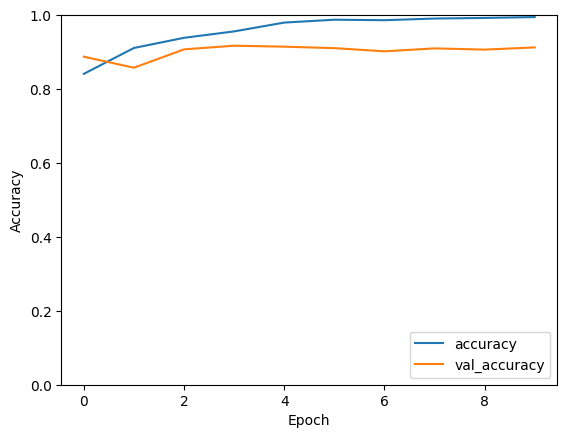

In [16]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

48/48 [==============================] - 3s 70ms/step - loss: 0.3709 - accuracy: 0.9126
Test Accuracy: 0.9126406311988831


In [20]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
y_pred = (model.predict(X_test) > 0.5).astype("int32")

48/48 [==============================] - 3s 70ms/step


In [21]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       766
           1       0.90      0.92      0.91       745

    accuracy                           0.91      1511
   macro avg       0.91      0.91      0.91      1511
weighted avg       0.91      0.91      0.91      1511



In [22]:
test_accuracy_resnet152 = accuracy_score(y_test, y_pred)
test_precision_resnet152 = precision_score(y_test, y_pred)
test_recall_resnet152 = recall_score(y_test, y_pred)
test_f1_resnet152 = f1_score(y_test, y_pred)

In [25]:
print(f"Test Accuracy: {test_accuracy_resnet152}")
print(f"Test Precision: {test_precision_resnet152}")
print(f"Test Recall: {test_recall_resnet152}")
print(f"Test F1 Score: {test_f1_resnet152}")

Test Accuracy: 0.9126406353408338
Test Precision: 0.9017038007863696
Test Recall: 0.9234899328859061
Test F1 Score: 0.9124668435013262


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [40]:
# Prepare dataset paths and labels
images = []
labels = []
for subfolder in tqdm(os.listdir('/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data')):
    subfolder_path = os.path.join('/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data', subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

100%|██████████| 2/2 [00:00<00:00, 164.34it/s]


In [41]:
# Create a DataFrame with image paths and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [42]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42, shuffle=True, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)

In [43]:
# Create separate DataFrames for train, validation, and test sets
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

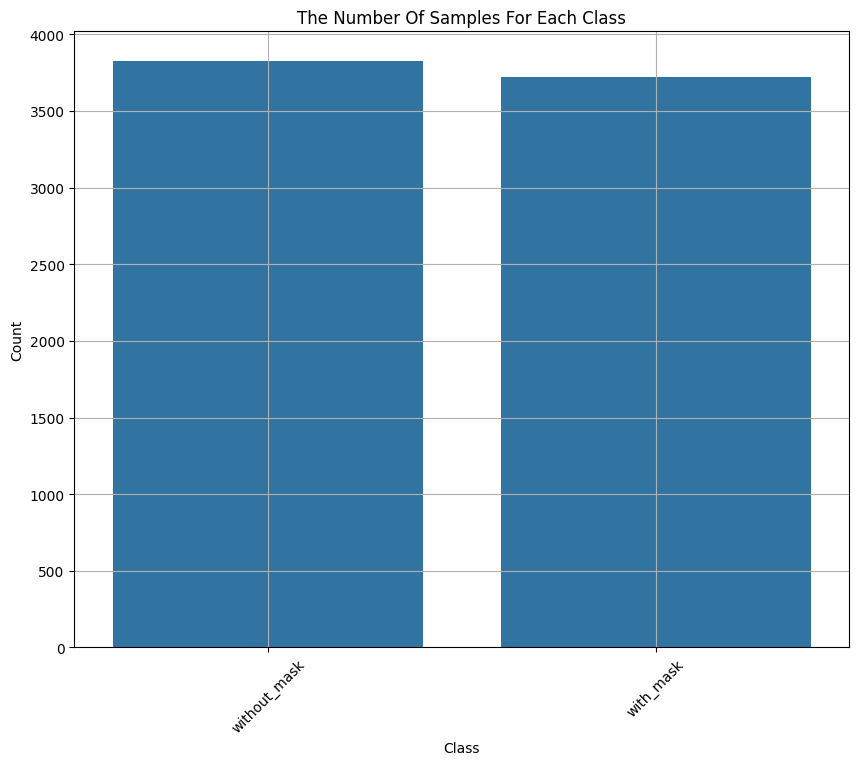

In [44]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.label)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title('The Number Of Samples For Each Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [45]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [46]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [47]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [48]:
model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation='softmax')  # Binary classification
])

# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               16056576  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18315074 (69.87 MB)
Trainable params: 16057090 (61.25 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [49]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("face_model_mobilenet.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
 33/166 [====>.........................] - ETA: 36s - loss: 1.6242 - accuracy: 0.9337

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - ETA: 0s - loss: 0.8014 - accuracy: 0.9654

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 57s 331ms/step - loss: 0.8014 - accuracy: 0.9654 - val_loss: 0.2192 - val_accuracy: 0.9859
Epoch 2/20
166/166 [==============================] - 53s 319ms/step - loss: 0.1401 - accuracy: 0.9909 - val_loss: 0.1914 - val_accuracy: 0.9894
Epoch 3/20
166/166 [==============================] - 53s 319ms/step - loss: 0.0518 - accuracy: 0.9956 - val_loss: 0.1143 - val_accuracy: 0.9929
Epoch 4/20
166/166 [==============================] - 54s 326ms/step - loss: 0.0731 - accuracy: 0.9968 - val_loss: 0.2619 - val_accuracy: 0.9841
Epoch 5/20
166/166 [==============================] - 55s 329ms/step - loss: 0.0708 - accuracy: 0.9956 - val_loss: 0.2799 - val_accuracy: 0.9806
Epoch 6/20
166/166 [==============================] - 55s 328ms/step - loss: 0.2165 - accuracy: 0.9972 - val_loss: 0.1605 - val_accuracy: 0.9903
Epoch 7/20
166/166 [==============================] - 54s 323ms/step - loss: 0.0354 - accuracy: 0.9981 - val_loss: 0.2048 - val_accuracy: 0.9

In [52]:
history_df = pd.DataFrame(history.history)


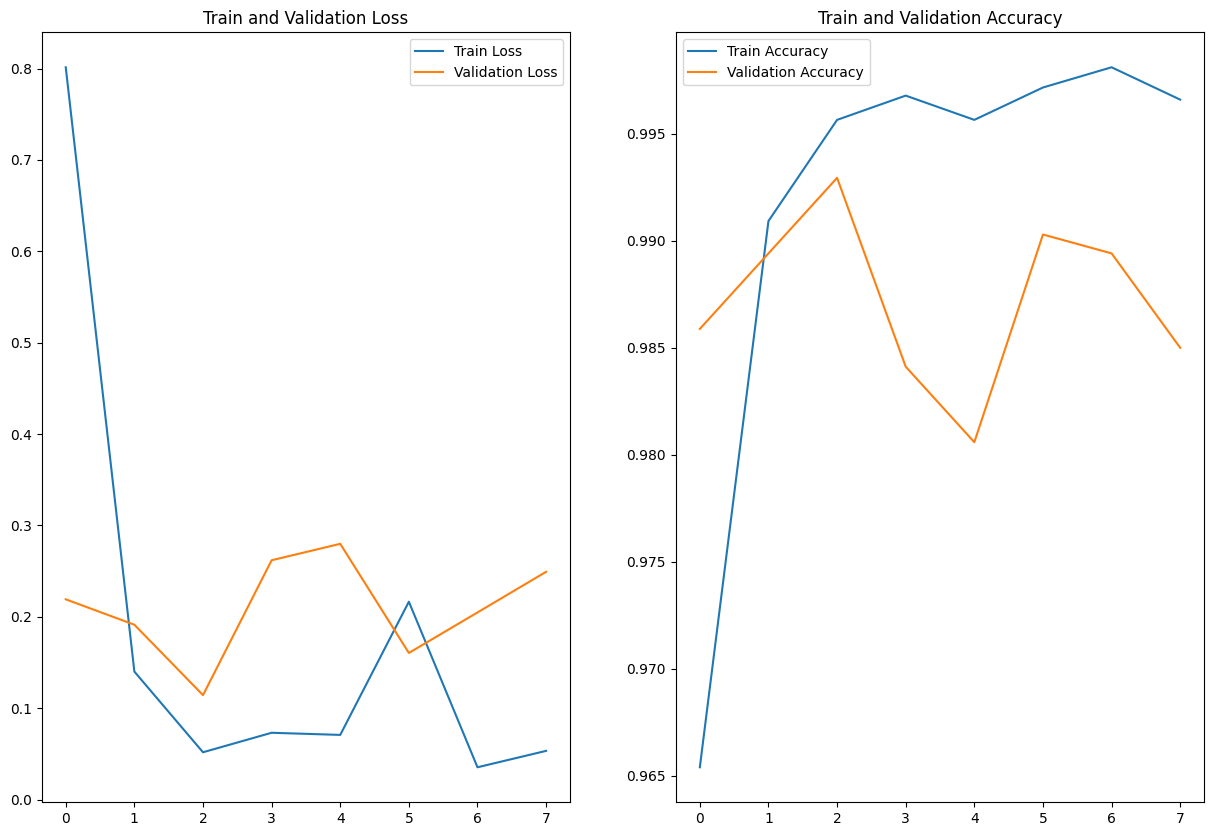

In [53]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [54]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

36/36 [==============================] - 8s 215ms/step - loss: 0.4882 - accuracy: 0.9841
Test Loss: 0.4881589710712433
Test Accuracy: 0.9841129779815674


In [55]:
y_true = test_generator.classes  # True labels
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

36/36 [==============================] - 8s 199ms/step


In [56]:
# Generate classification report and confusion matrix
classification_report_str = classification_report(y_true, y_pred, target_names=['with_mask', 'without_mask'])
print("Classification Report:\n", classification_report_str)

Classification Report:
               precision    recall  f1-score   support

   with_mask       0.99      0.98      0.98       559
without_mask       0.98      0.99      0.98       574

    accuracy                           0.98      1133
   macro avg       0.98      0.98      0.98      1133
weighted avg       0.98      0.98      0.98      1133



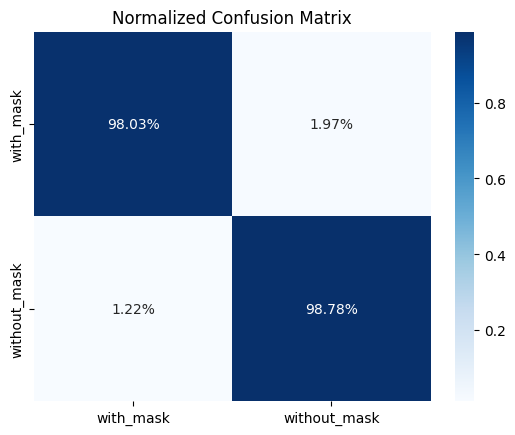

In [57]:
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=['with_mask', 'without_mask'], yticklabels=['with_mask', 'without_mask'])
plt.title("Normalized Confusion Matrix")
plt.show()

In [58]:
test_metrics = {
    'accuracy': test_accuracy,
    'loss': test_loss,
    'classification_report': classification_report_str,
    'confusion_matrix': conf_matrix
}

In [59]:
# Display metrics for further analysis if needed
print("Stored Test Metrics:", test_metrics)

Stored Test Metrics: {'accuracy': 0.9841129779815674, 'loss': 0.4881589710712433, 'classification_report': '              precision    recall  f1-score   support\n\n   with_mask       0.99      0.98      0.98       559\nwithout_mask       0.98      0.99      0.98       574\n\n    accuracy                           0.98      1133\n   macro avg       0.98      0.98      0.98      1133\nweighted avg       0.98      0.98      0.98      1133\n', 'confusion_matrix': array([[548,  11],
       [  7, 567]])}


26/36 [====================>.........] - ETA: 2s - loss: 0.4921 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


36/36 [==============================] - 8s 209ms/step - loss: 0.4882 - accuracy: 0.9841
Test Loss: 0.4881589710712433
Test Accuracy: 0.9841129779815674
36/36 [==============================] - 8s 207ms/step
Classification Report:
               precision    recall  f1-score   support

   with_mask       0.99      0.98      0.98       559
without_mask       0.98      0.99      0.98       574

    accuracy                           0.98      1133
   macro avg       0.98      0.98      0.98      1133
weighted avg       0.98      0.98      0.98      1133



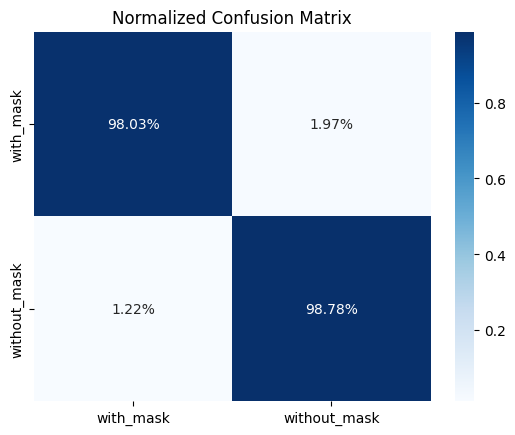

Stored Test Metrics: {'test_loss': 0.4881589710712433, 'test_accuracy': 0.9841129779815674, 'overall_accuracy': 0.9841129744042365, 'overall_f1_score': 0.9841085053859964, 'with_mask_precision': 0.9873873873873874, 'with_mask_recall': 0.9803220035778175, 'without_mask_precision': 0.9809688581314879, 'without_mask_recall': 0.9878048780487805, 'confusion_matrix': array([[548,  11],
       [  7, 567]])}


In [60]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
y_true = test_generator.classes  # True labels
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
classification_report_dict = classification_report(y_true, y_pred, target_names=['with_mask', 'without_mask'], output_dict=True)
classification_report_str = classification_report(y_true, y_pred, target_names=['with_mask', 'without_mask'])
print("Classification Report:\n", classification_report_str)

# Confusion matrix and its normalized version
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=['with_mask', 'without_mask'], yticklabels=['with_mask', 'without_mask'])
plt.title("Normalized Confusion Matrix")
plt.show()

# Store individual metrics in variables for easy comparison
with_mask_precision = classification_report_dict['with_mask']['precision']
with_mask_recall = classification_report_dict['with_mask']['recall']
without_mask_precision = classification_report_dict['without_mask']['precision']
without_mask_recall = classification_report_dict['without_mask']['recall']
overall_accuracy = classification_report_dict['accuracy']
overall_f1_score = classification_report_dict['macro avg']['f1-score']

# Organize all metrics in a dictionary
test_metrics = {
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
    'overall_accuracy': overall_accuracy,
    'overall_f1_score': overall_f1_score,
    'with_mask_precision': with_mask_precision,
    'with_mask_recall': with_mask_recall,
    'without_mask_precision': without_mask_precision,
    'without_mask_recall': without_mask_recall,
    'confusion_matrix': conf_matrix
}

# Display metrics for further analysis if needed
print("Stored Test Metrics:", test_metrics)
